In [22]:
import IPython
import tensorflow as tf

from trigger_word_model.trigger_word_detection import TriggerWordDetection
from speech_to_text.speech_to_text import SpeechToText

from q_a_model.document_reader import DocumentReader
from q_a_model.paragraph_ranker import ParagraphRanker
from q_a_model.document_retriever import DocumentRetriever

In [24]:
raw_audio = "test1.wav"
es_index = "wikipedia-full"
es_config = {'host':'localhost', 'port':9200}
model_name = "ktrapeznikov/albert-xlarge-v2-squad-v2"
tokenizer_name = "ktrapeznikov/albert-xlarge-v2-squad-v2"

In [23]:
def get_chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [4]:
twd = TriggerWordDetection('/home/novarac23/Projects/jarvis/trigger_word_model/saved_model/v2_3')

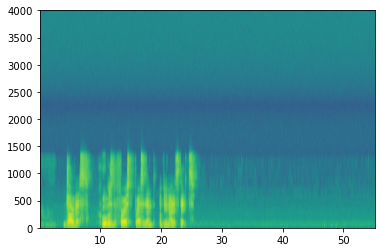

In [12]:
predictions = twd.detect_trigger_word(raw_audio)

In [13]:
ind = tf.argmax(predictions, axis=1)
predictions[0, int(ind[0][0]), 0]

0.9939784

In [14]:
audio_path = twd.cut_audio_on_trigger_word(raw_audio, predictions, .99)

In [15]:
audio_path

'cut_test1.wav'

In [16]:
IPython.display.Audio(raw_audio)

In [17]:
IPython.display.Audio(audio_path)

In [19]:
stt = SpeechToText(audio_path)

In [20]:
question = stt.convert()

In [21]:
question

'who was the first president of the United States'

In [25]:
dr = DocumentRetriever(es_config)

In [46]:
documents = dr.retrieve_docs(question, es_index, size=5, title=False)

In [47]:
documents

{'took': 105,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 15.566998,
  'hits': [{'_index': 'wikipedia-full',
    '_type': '_doc',
    '_id': 'lDHaFnQBPcTp58A52Dpw',
    '_score': 15.566998,
    '_source': {'document_title': 'List of presidents of the United States who owned slaves',
     'document_text': 'List of presidents of the United States who owned slavesList of presidents of the United States who owned slaves\n\nThis is a list of presidents of the United States who owned slaves. Slavery was legal in the United States from its beginning as a nation, having been practiced in North America from early colonial days. The Thirteenth Amendment to the United States Constitution formally abolished slavery in 1865, immediately after the end of the American Civil War. In total, twelve U.S. presidents owned slaves at some point in their lives; of these, eight owned slaves wh

In [48]:
pr = ParagraphRanker(documents)

In [49]:
contexts = pr.rank_paragaraphs(question, n_paragraphs=8)

In [50]:
contexts

['The United States elections of 1788–89 were the first federal elections in the United States following the ratification of the United States Constitution in 1788. In the elections, George Washington was elected as the first president and the members of the 1st United States Congress were selected.',
 'The presidential election of 1788–1789 was the first election of a federal head of state or head of government in United States history. Prior to the ratification of the United States Constitution in 1788, the U.S. had been governed under the Articles of Confederation, which provided for a very limited central government; what power that did exist was vested in the Congress of the Confederation, a unicameral legislature consisting of representatives elected by the states. The Congress of the Confederation had elected a president, but this position was largely ceremonial and was not equivalent to the presidency that was established by the United States Constitution.',
 'The first family 

In [36]:
doc_reader = DocumentReader(model_name, tokenizer_name)

All PyTorch model weights were used when initializing TFAlbertForQuestionAnswering.

All the weights of TFAlbertForQuestionAnswering were initialized from the TF 2.0 model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFAlbertForQuestionAnswering for predictions without further training.


In [51]:
results = []

for i, context in enumerate(contexts):        
    try:
        if len(context) > 512:
            print('context length for item {i} is bigger then 512, need to perform chunking')
            chunks = list(get_chunks(context, 511))
            for chunk in chunks:
                final_answer = doc_reader.get_answer(question, chunk)
                results.append(final_answer)
        
        
        final_answer = doc_reader.get_answer(question, context)
        
        results.append(final_answer)
    except Exception as e:
        print(f'We could not process item under {i}. Reason is: {e}')

context length for item {i} is bigger then 512, need to perform chunking
context length for item {i} is bigger then 512, need to perform chunking
context length for item {i} is bigger then 512, need to perform chunking
context length for item {i} is bigger then 512, need to perform chunking


In [52]:
results

[('george washington', 0.49226055),
 ('', 0.35414916),
 ('', 0.9996106),
 ('', 0.32948557),
 ('', 0.9999988),
 ('', 0.99999905),
 ('', 0.99999857),
 ('general george washington', 0.695135),
 ('', 0.99999833),
 ('', 0.99990845),
 ('', 0.99999964),
 ('', 0.9999995),
 ('', 0.9999995),
 ('', 0.99999964),
 ('george washington', 0.40487236),
 ('', 0.95435035),
 ('george washington was the first president who owned slaves', 0.56550545)]